<a href="https://colab.research.google.com/github/supertulli/ChangeMonitoring/blob/dask/PDFChangeDetectorAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!git clone https://github.com/supertulli/ChangeMonitoring.git

Cloning into 'ChangeMonitoring'...
remote: Enumerating objects: 1183, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 1183 (delta 155), reused 231 (delta 144), pack-reused 935 (from 1)
Receiving objects: 100% (1183/1183), 52.97 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (806/806), done.
Updating files: 100% (1016/1016), done.


In [21]:
%cd ChangeMonitoring

/content/ChangeMonitoring/ChangeMonitoring


In [22]:
!pip install -r requirements.txt

In [23]:
from google.colab import output
output.enable_custom_widget_manager()

In [24]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider

from scipy.stats import beta
import numpy as np


In [25]:
%matplotlib ipympl

from re import X


def plot_slider_animation(alpha_estimates_list,
                        beta_estimates_list,
                        min_u1s_list,
                        min_u2s_list,
                        min_u3s_list,
                        current_u1s_list,
                        first_frame, last_frame,
                        y_min=0, y_max=100, x_min=0, x_max=0.3):

    framed_time=slice(first_frame, last_frame)

    frame_data_list = list(zip(alpha_estimates_list[framed_time], beta_estimates_list[framed_time],
                min_u1s_list[framed_time], min_u2s_list[framed_time], min_u3s_list[framed_time],
                current_u1s_list[framed_time],
                range(first_frame, last_frame)))



    a_process, b_process, min_u1, min_u2, min_u3, current_u1, start_time = frame_data_list.pop(0)
    end_time = frame_data_list[-1][-1]

    fig, ax = plt.subplots(figsize=(15,7))

    if (a_process is not None) and (b_process is not None):
        x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
        y_process = beta.pdf(x_process, a_process, b_process)
        line_process = ax.plot(x_process, y_process, 'b-', label='distance do reference distribution')[0]
    else:
        line_process = ax.plot([], [], 'b-', label='distance to reference distribution')[0]

    if current_u1 is not None:
        u1_process = ax.axvline(current_u1, ymin=0, ymax= beta.pdf(current_u1, a_process, b_process), color="blue", linestyle="dashdot", label='current u1')
    else:
        u1_process = ax.axvline(0, ymin=0, ymax= 0, color="blue", linestyle="dashdot")

    if min_u1 is not None:
        u1_marker = ax.plot([min_u1], [0], marker='^', markersize=y_max*0.05, color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.plot([min_u2], [0], marker='^', markersize=y_max*0.05, color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.plot([min_u3], [0], marker='^', markersize=y_max*0.05, color="red", alpha=0.5, label="u3_threshold")
    else:
        u1_marker = ax.plot([], [], marker='^', markersize=y_max*0.05, color="green", alpha=0.5, label="u1_threshold")
        u2_marker = ax.plot([], [], marker='^', markersize=y_max*0.05, color="orange", alpha=0.5, label="u2_threshold")
        u3_marker = ax.plot([], [], marker='^', markersize=y_max*0.05, color="red", alpha=0.5, label="u3_threshold")

    ax.set(xlim=(x_min, x_max), xlabel='Values of Random Variable X (0, 1)',
        ylim=(y_min,y_max), ylabel='Probability density', title='Beta Distribution of pdf distances to reference distribution')
    time_legend = ax.text(0.9, 0.95, f'time: {start_time}', ha='left', va='top', transform=ax.transAxes,
                    bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'))
    ax.legend(loc='lower right')

    # adjust the main plot to make room for the sliders
    fig.subplots_adjust(left=0.25, bottom=0.25)

    # Make a horizontal slider to control the frequency.
    axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    freq_slider = Slider(
        ax=axfreq,
        label='Time step',
        valmin=start_time,
        valmax=end_time,
        valinit=start_time,
    )

    # Plot the beta distribution
    def update(val):

        idx = int(freq_slider.val-start_time)
        a_process, b_process, min_u1, min_u2, min_u3, current_u1, time = frame_data_list[idx]

        if (a_process is not None) and (b_process is not None):
            x_process = np.linspace(beta.ppf(0.001, a_process, b_process),beta.ppf(0.999, a_process, b_process), 1000)
            y_process = beta.pdf(x_process, a_process, b_process)
            line_process.set_data(x_process, y_process)
        else:
            line_process.set_data([], [])

        if current_u1 is not None:
            u1_process.set_xdata([current_u1, current_u1])
            u1_process.set_ydata([0,beta.pdf(current_u1, a_process, b_process)])
        else:
            u1_process.set_xdata([0,0])
            u1_process.set_ydata([0,0])

        if min_u1 is not None:
            u1_marker[0].set_xdata([min_u1])
            u1_marker[0].set_ydata([0])
            u2_marker[0].set_xdata([min_u2])
            u2_marker[0].set_ydata([0])
            u3_marker[0].set_xdata([min_u3])
            u3_marker[0].set_ydata([0])
        else:
            u1_marker[0].set_xdata([])
            u1_marker[0].set_ydata([])
            u2_marker[0].set_xdata([])
            u2_marker[0].set_ydata([])
            u3_marker[0].set_xdata([])
            u3_marker[0].set_ydata([])

        time_legend.set_text(f'time: {time}')

        fig.canvas.draw_idle()

    # register the update function with each slider
    freq_slider.on_changed(update)
    # Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
    resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', hovercolor='0.975')

    def reset(event):
        freq_slider.reset()

    button.on_clicked(reset)

    plt.show()

In [26]:
from random import gauss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
def gaussian_histogram(mu:float, sigma:float, sample_size:int):
    bin_edges = np.linspace(-10,10,21)
    histogram, _ = np.histogram([gauss(mu, sigma) for _ in range(sample_size)], bins=bin_edges, density=True)
    return pd.Series(histogram)

In [28]:
gaussian_histogram(0, 1, 10000)

,0
0,0.0000
1,0.0000
2,0.0000
3,0.0000
4,0.0000
5,0.0000
6,0.0017
7,0.0224
8,0.1300
9,0.3496


In [29]:
from src.change_detector import detect_response
from src.change_detector.corrected_change_detector import PDFChangeDetector


change_detector = PDFChangeDetector()

for i in range(500):
    new_pdf = gaussian_histogram(0, 1, 10000)
    detect_response = change_detector.detect_change(new_pdf)
    print("Status:", detect_response.state.name, "| Alpha:", detect_response.alpha_estimate,"| Beta:", detect_response.beta_estimate,"\n***\n")

current process run_order: 1
Status: LEARNING | Alpha: None | Beta: None 
***

current process run_order: 2 

Status: LEARNING | Alpha: None | Beta: None 
***

current process run_order: 3 

Status: LEARNING | Alpha: 112.64656285796755 | Beta: 11627.473495534117 
***

current process run_order: 4 

Status: LEARNING | Alpha: 147.8988290247202 | Beta: 15354.313919449149 
***

current process run_order: 5 

Status: LEARNING | Alpha: 88.17143958901977 | Beta: 8785.676844733367 
***

current process run_order: 6 

Status: LEARNING | Alpha: 95.94717516693717 | Beta: 9424.041759659423 
***

current process run_order: 7 

Status: LEARNING | Alpha: 111.69005830517385 | Beta: 10988.533806947053 
***

current process run_order: 8 

Status: LEARNING | Alpha: 79.03858246438031 | Beta: 7560.096978159881 
***

current process run_order: 9 

Status: LEARNING | Alpha: 73.03018184827347 | Beta: 6857.3461436655025 
***

current process run_order: 10 

Status: LEARNING | Alpha: 81.0598732820125 | Beta: 76

In [30]:
from src.change_detector.corrected_change_detector import PDFChangeDetector


change_detector_window = PDFChangeDetector(method="window")

for i in range(200):
    new_pdf = gaussian_histogram(0, 1, 10000)
    detect_response = change_detector_window.detect_change(new_pdf)
    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta :", detect_response.beta_estimate,
        "\n***\n")

current process run_order: 1
Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 2 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 3 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 4 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 5 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 6 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 7 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 8 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 9 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 10 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 11 

Status:  LEARNING | Alpha : None | Beta : None 
***

current process run_order: 12 

Status:  LEARNING | Alpha : None | Beta : No

In [31]:
change_detector.current_process.__dict__

{'_monitor_method': <MonitorMethod.TRUNCATED: 0>,
 '_monitor_size': 100,
 'reference_PDF': 0     0.000000
 1     0.000000
 2     0.000000
 3     0.000000
 4     0.000000
 5     0.000030
 6     0.001380
 7     0.021350
 8     0.136135
 9     0.341630
 10    0.341875
 11    0.134800
 12    0.021420
 13    0.001355
 14    0.000025
 15    0.000000
 16    0.000000
 17    0.000000
 18    0.000000
 19    0.000000
 dtype: float64,
 'alpha_fading_pdf': 0     0.0000
 1     0.0000
 2     0.0000
 3     0.0000
 4     0.0000
 5     0.0000
 6     0.0017
 7     0.0192
 8     0.1366
 9     0.3369
 10    0.3500
 11    0.1338
 12    0.0206
 13    0.0012
 14    0.0000
 15    0.0000
 16    0.0000
 17    0.0000
 18    0.0000
 19    0.0000
 dtype: float64,
 'estimated_alpha': 21.176319727497347,
 'estimated_beta': 1699.3712185031281,
 'run_order': 472,
 'dist_geo_mean': 0.012020783884128352,
 'complementary_dist_geo_mean': 0.9876885264756805,
 'min_u1': 0.014584242186480701,
 'min_u2': 0.017122991544897933,


In [32]:
from src.change_detector.corrected_change_detector import PDFChangeDetector

change_detector = PDFChangeDetector(reference_size=30)

detection_status_list = []
alpha_estimates_list = []
beta_estimates_list = []
u1_min_list = []
u2_min_list = []
u3_min_list = []
current_u1_list = []

for i in range(300):
    new_pdf = gaussian_histogram(2, 1, 10000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")


for i in range(100):
    new_pdf = gaussian_histogram(2.1, 1, 10000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")

current process run_order: 1
Status:  LEARNING | Alpha : None | Beta None 
***

current process run_order: 2 

Status:  LEARNING | Alpha : None | Beta None 
***

current process run_order: 3 

Status:  LEARNING | Alpha : 34.34231255757903 | Beta 3898.4965365592043 
***

current process run_order: 4 

Status:  LEARNING | Alpha : 44.48990914767556 | Beta 4977.605375963312 
***

current process run_order: 5 

Status:  LEARNING | Alpha : 45.42887074977036 | Beta 5239.816168646973 
***

current process run_order: 6 

Status:  LEARNING | Alpha : 47.21679896933822 | Beta 5311.439501523344 
***

current process run_order: 7 

Status:  LEARNING | Alpha : 36.42876782910361 | Beta 3924.683020768503 
***

current process run_order: 8 

Status:  LEARNING | Alpha : 41.59367520595441 | Beta 4478.679170275351 
***

current process run_order: 9 

Status:  LEARNING | Alpha : 12.73418142934909 | Beta 1231.1210207087074 
***

current process run_order: 10 

Status:  LEARNING | Alpha : 14.055127615210571 |

In [33]:
data = pd.DataFrame([detection_status_list, alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list]).T

In [34]:
data

,0,1,2,3,4,5,6
0,LEARNING,None,None,None,None,None,None
1,LEARNING,None,None,None,None,None,None
2,LEARNING,34.342313,3898.496537,None,None,None,None
3,LEARNING,44.489909,4977.605376,None,None,None,None
4,LEARNING,45.428871,5239.816169,None,None,None,None
...,...,...,...,...,...,...,...
395,IN_CONTROL,24.688431,1962.602926,0.014235,0.016972,0.020162,0.014876
396,IN_CONTROL,24.933143,1982.964934,0.014235,0.016972,0.020162,0.014858
397,IN_CONTROL,25.14,2001.206059,0.014235,0.016972,0.020162,0.014835
398,IN_CONTROL,25.394312,2021.051277,0.014235,0.016972,0.020162,0.014826


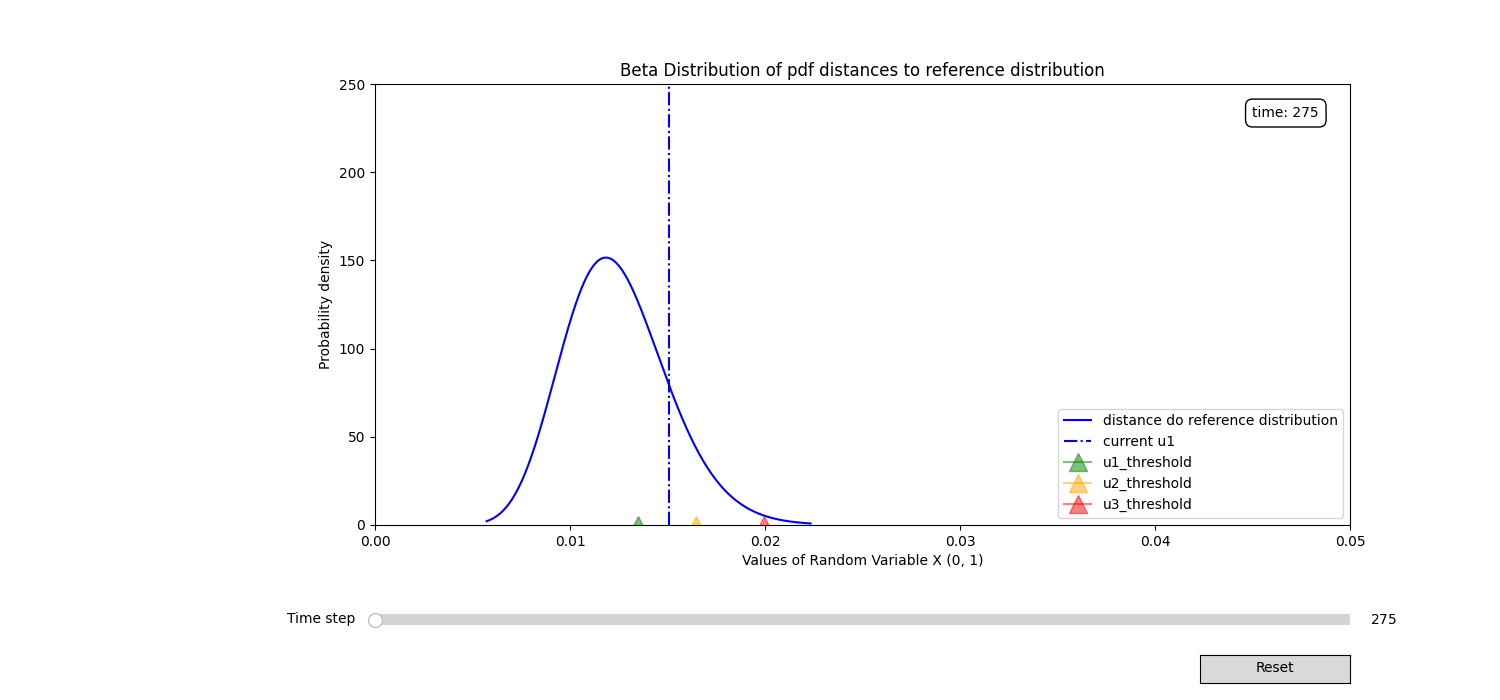

In [35]:
plot_slider_animation(alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list, first_frame=275, last_frame=350, y_max=250, x_max=0.05)

In [36]:
change_detector = PDFChangeDetector(reference_size=30)

detection_status_list = []
alpha_estimates_list = []
beta_estimates_list = []
u1_min_list = []
u2_min_list = []
u3_min_list = []
current_u1_list = []

for i in range(500):
    new_pdf = gaussian_histogram(2, 1, 1000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")


for i in range(50):
    new_pdf = gaussian_histogram(2, 1.2, 1000)
    detect_response = change_detector.detect_change(new_pdf)

    detection_status_list.append(detect_response.state.name)
    alpha_estimates_list.append(detect_response.alpha_estimate)
    beta_estimates_list.append(detect_response.beta_estimate)
    u1_min_list.append(detect_response.min_u1)
    u2_min_list.append(detect_response.min_u2)
    u3_min_list.append(detect_response.min_u3)
    current_u1_list.append(detect_response.current_u1)

    print("Status: ", detect_response.state.name,
        "| Alpha :", detect_response.alpha_estimate,
        "| Beta", detect_response.beta_estimate,
        "\n***\n")

current process run_order: 1
Status:  LEARNING | Alpha : None | Beta None 
***

current process run_order: 2 

Status:  LEARNING | Alpha : None | Beta None 
***

current process run_order: 3 

Status:  LEARNING | Alpha : 4.4547912034817525 | Beta 211.45587131016012 
***

current process run_order: 4 

Status:  LEARNING | Alpha : 4.697637787859972 | Beta 192.9554085592641 
***

current process run_order: 5 

Status:  LEARNING | Alpha : 5.454196343529088 | Beta 235.74319199608212 
***

current process run_order: 6 

Status:  LEARNING | Alpha : 4.970898480235477 | Beta 190.06918408554998 
***

current process run_order: 7 

Status:  LEARNING | Alpha : 5.475434209277377 | Beta 200.20615933034577 
***

current process run_order: 8 

Status:  LEARNING | Alpha : 5.838957267073418 | Beta 204.03496338490635 
***

current process run_order: 9 

Status:  LEARNING | Alpha : 6.143915045765552 | Beta 206.08809209424447 
***

current process run_order: 10 

Status:  LEARNING | Alpha : 6.3917824978340

In [37]:
data = pd.DataFrame([detection_status_list, alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list]).T

In [38]:
data

,0,1,2,3,4,5,6
0,LEARNING,None,None,None,None,None,None
1,LEARNING,None,None,None,None,None,None
2,LEARNING,4.454791,211.455871,None,None,None,None
3,LEARNING,4.697638,192.955409,None,None,None,None
4,LEARNING,5.454196,235.743192,None,None,None,None
...,...,...,...,...,...,...,...
545,IN_CONTROL,18.027213,434.338971,0.048878,0.059747,0.072517,0.048916
546,IN_CONTROL,17.517843,425.235679,0.048695,0.059578,0.072372,0.048695
547,IN_CONTROL,17.535889,427.793215,0.048459,0.059286,0.072014,0.048459
548,IN_CONTROL,17.875317,435.249792,0.048459,0.059286,0.072014,0.048462


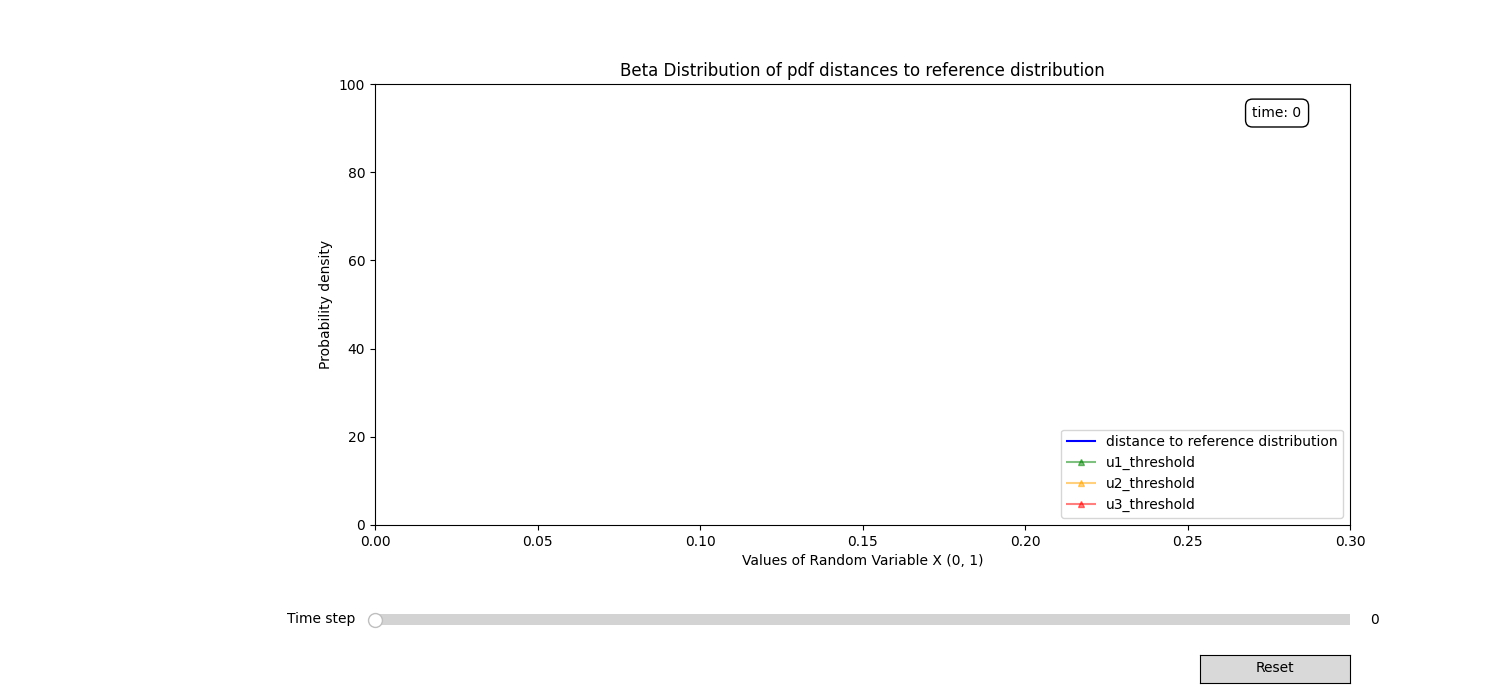

In [39]:
plot_slider_animation(alpha_estimates_list, beta_estimates_list, u1_min_list, u2_min_list, u3_min_list, current_u1_list, first_frame=0, last_frame=549)